In [1]:
from pyspark.sql import SparkSession
import os
from plotnine import *
import pandas as pd
import numpy as np

import pyspark.sql.functions as F

In [2]:
traces_location = "<location to dir with trace directories>"
list_of_workloads = list(map(lambda x: os.path.join(traces_location, x), os.listdir(traces_location)))
# list_of_workloads

In [3]:
name_to_domain_map = {
    "askalon-new": "Scientific",
    "askalon": "Engineering",
    "icpe": "Scientific",
    "lanl": "Scientific",
    "pegasus": "Scientific",
    "workflowhub": "Scientific",
    "two": "Industry",
    "google": "Industry",
    "chronos": "Industry",
    "alibaba": "Industry",
}

# If a folder name (in lower case) starts with one of these strings, it has critical path info computed.
has_cp_info = [
    "askalon",
    "icpe",
    "pegasus",
    "workflowhub",
    "chronos",
    "alibaba",
]

In [4]:
spark = (SparkSession.builder
         .master("local[4]")
         .appName("Longitudinal Analysis")
         .config("spark.executor.memory", "8G")
         .config("spark.driver.memory", "2G")
         .getOrCreate())

In [5]:
def folder_name_to_domain(folder_name):
    for name, domain in name_to_domain_map.items():
        if str(folder_name).startswith(name): return domain
    raise NotImplementedError("Unknown folder!")

In [6]:
def do_workflows_exist(workload_location):
    return "workflows" in os.listdir(workload_location)

def read_trace(workload_location):
    return spark.read.parquet(os.path.join(workload_location, "workflows", "schema-1.0"))

In [48]:
def get_cp_task_count_column(df):
    return (df.select("critical_path_task_count", "critical_path_length")
            .filter(F.col("critical_path_task_count") > 0)
            .withColumnRenamed("critical_path_task_count", "cp_task_count")
            .withColumnRenamed("critical_path_length", "cp_length"))

In [66]:
list_of_dfs = []
for workload in list_of_workloads:
    folder_name = str(os.path.basename(os.path.normpath(workload))).lower()
    
    if not any(folder_name.startswith(x) for x in has_cp_info):
        continue
        
    if not do_workflows_exist(workload):
        continue
    
    trace = read_trace(workload)
    pdf = get_cp_task_count_column(trace).toPandas()
    domain = folder_name_to_domain(folder_name)
    pdf["domain"] = domain
    pdf["workload"] = folder_name
    
#     print(folder_name, " => ", domain, " ({0} workflows, {1} unique cps)".format(len(pdf), pdf["cp_task_count"].nunique()))
#     print("Largest cp: ", pdf["cp_task_count"].max())
    
    list_of_dfs.append(pdf)

workflow_task_count_df = pd.concat(list_of_dfs, ignore_index = True)

In [61]:
def formatOneLabel(x):
    if x == 0:
        return "0"
    else:
        exponentNum = str(np.int32(np.floor(np.log10(x))))
        return "$10^{"+ exponentNum +"}$"


def formatYaxisLabels(xl):
    return list(map(formatOneLabel, xl))

In [86]:
def normalize_df(df, col_name):
    sorted_df = df.sort_values(col_name)
    sorted_df["pdf"] = sorted_df["count"] / sorted_df["count"].sum()
    sorted_df["cdf"] = sorted_df["pdf"].cumsum()
    return sorted_df

def normalize_group(df, col_name):
    counted = df.groupby(col_name).count().reset_index().rename(columns={"domain":"count"})
    return normalize_df(counted, col_name)[[col_name, "pdf", "cdf"]]

def normalize_workload_and_group(df, col_name):
    counted = df.groupby(col_name).sum().reset_index().rename(columns={"pdf":"count"})
    return normalize_df(counted, col_name)[[col_name, "pdf", "cdf"]]

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 3 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/crit_path_task_count_normalized_domain_stratified.pdf
  warn('Filename: {}'.format(filename))


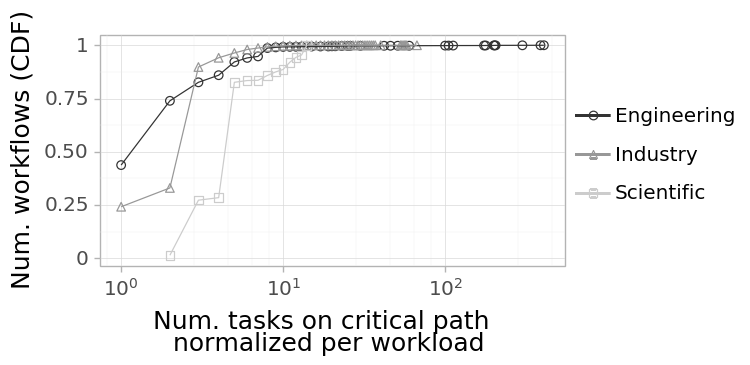

<ggplot: (-9223369104748499659)>

In [90]:
workflow_task_count_pdf1_df = workflow_task_count_df.groupby(["workload", "domain"]).apply(normalize_group, "cp_task_count").reset_index()
workflow_task_count_pdf_df = (workflow_task_count_pdf1_df.groupby("domain")
                              .apply(normalize_workload_and_group, "cp_task_count")
                              .reset_index())

plt = ggplot(workflow_task_count_pdf_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
         legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="cp_task_count", y="cdf", color="domain", shape="domain"), stat=stat_identity, size=3, fill="none") +\
    geom_line(aes(x="cp_task_count", y="cdf", color="domain", group="domain"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Num. tasks on critical path \n normalized per workload") +\
    ylab("Num. workflows (CDF)") +\
    scale_x_log10(labels=formatYaxisLabels)

os.makedirs("./plots", exist_ok=True)
ggsave(filename="./plots/crit_path_task_count_normalized_domain_stratified.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=3,
       width=6)
plt

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 3 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/crit_path_task_count_unnormalized_domain_stratified.pdf
  warn('Filename: {}'.format(filename))


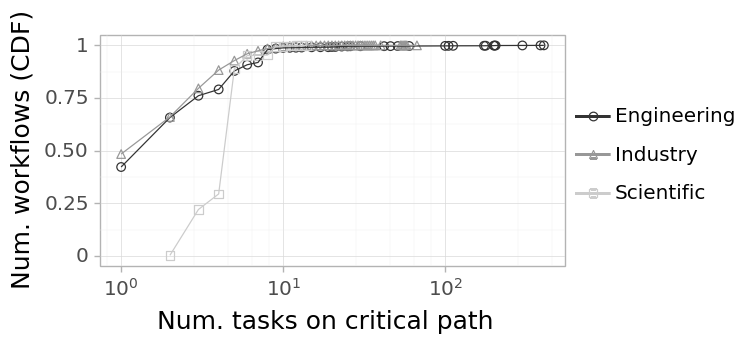

<ggplot: (-9223369104759673768)>

In [93]:
workflow_task_count_pdf_df = workflow_task_count_df.groupby("domain").apply(normalize_group, "cp_task_count").reset_index()

plt = ggplot(workflow_task_count_pdf_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
         legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="cp_task_count", y="cdf", color="domain", shape="domain"), stat=stat_identity, size=3, fill="none") +\
    geom_line(aes(x="cp_task_count", y="cdf", color="domain", group="domain"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Num. tasks on critical path") +\
    ylab("Num. workflows (CDF)") +\
    scale_x_log10(labels=formatYaxisLabels)

os.makedirs("./plots", exist_ok=True)
ggsave(filename="./plots/crit_path_task_count_unnormalized_domain_stratified.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=3,
       width=6)
plt

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 3 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/crit_path_length_normalized_domain_stratified.pdf
  warn('Filename: {}'.format(filename))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


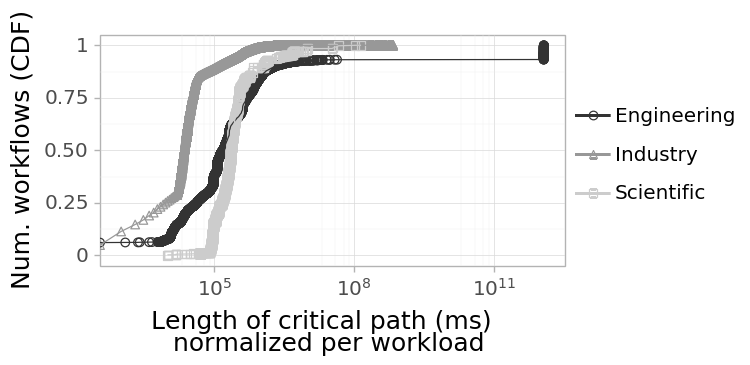

<ggplot: (-9223369104748599366)>

In [92]:
workflow_length_pdf1_df = workflow_task_count_df.groupby(["workload", "domain"]).apply(normalize_group, "cp_length").reset_index()
workflow_length_pdf_df = (workflow_length_pdf1_df.groupby("domain")
                              .apply(normalize_workload_and_group, "cp_length")
                              .reset_index())

plt = ggplot(workflow_length_pdf_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
         legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="cp_length", y="cdf", color="domain", shape="domain"), stat=stat_identity, size=3, fill="none") +\
    geom_line(aes(x="cp_length", y="cdf", color="domain", group="domain"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Length of critical path (ms) \n normalized per workload") +\
    ylab("Num. workflows (CDF)") +\
    scale_x_log10(labels=formatYaxisLabels)

os.makedirs("./plots", exist_ok=True)
ggsave(filename="./plots/crit_path_length_normalized_domain_stratified.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=3,
       width=6)
plt

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 3 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/crit_path_length_unnormalized_domain_stratified.pdf
  warn('Filename: {}'.format(filename))


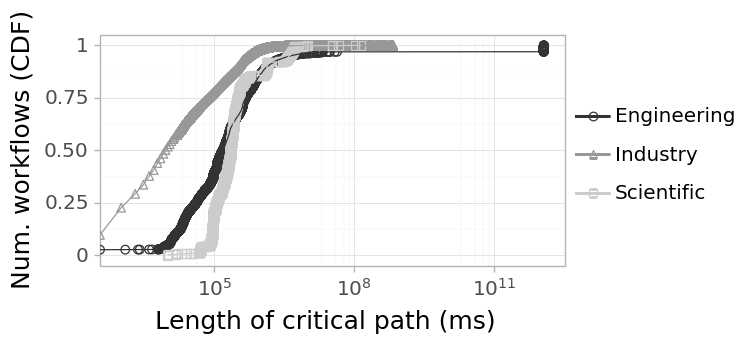

<ggplot: (-9223369104748769101)>

In [94]:
workflow_length_pdf_df = workflow_task_count_df.groupby("domain").apply(normalize_group, "cp_length").reset_index()

plt = ggplot(workflow_length_pdf_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
         legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="cp_length", y="cdf", color="domain", shape="domain"), stat=stat_identity, size=3, fill="none") +\
    geom_line(aes(x="cp_length", y="cdf", color="domain", group="domain"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Length of critical path (ms)") +\
    ylab("Num. workflows (CDF)") +\
    scale_x_log10(labels=formatYaxisLabels)

os.makedirs("./plots", exist_ok=True)
ggsave(filename="./plots/crit_path_length_unnormalized_domain_stratified.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=3,
       width=6)
plt